### Dataset: Weekly Product Sales
The dataset contains 104 weeks of training data and 39 weeks of test data. The time series is the product sales of a supermarket in a particular period. The goal is to predict sales in the test period. The training data is in "dep2train.csv" and the test data is in "dep2test.csv."

Below is the first few records of these two files:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
from datetime import datetime
import pandas as pd
dep2train = pd.read_csv('data/dep2train.csv')
print("Head of training data:")
print(dep2train.head())
dep2test = pd.read_csv('data/dep2test.csv')
print("Head of test data:")
print(dep2test.head())

Head of training data:
         date  weeklySales
0  2010-02-05    123952.48
1  2010-02-12    119209.48
2  2010-02-19    121430.80
3  2010-02-26    120292.15
4  2010-03-05    113163.91
Head of test data:
         date  weeklySales
0  2011-11-04    108655.66
1  2011-11-11    106841.49
2  2011-11-18     98341.91
3  2011-11-25     97213.06
4  2011-12-02     99976.34


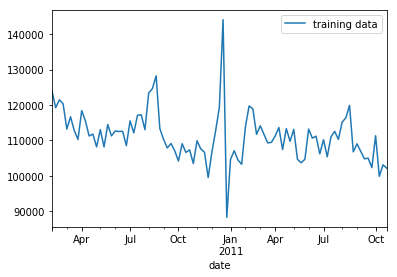

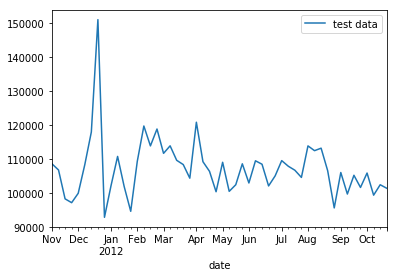

In [2]:
dep2train['date'] = pd.to_datetime(dep2train['date'])
dep2train['fold'] = 'train'
dep2test['date'] = pd.to_datetime(dep2test['date'])
dep2test['fold'] = 'test'

_ = dep2train.plot(y = 'weeklySales', x = 'date', label = 'training data')
_ = dep2test.plot(y = 'weeklySales', x = 'date', label = 'test data')

### Train-test Split and Expanding Window
A common way to compute prediction error (MAPE) is to use a train-test split. We train a model M1 using the training data and use M1 to make predictions. When doing this, we apply the model and every test record independently and compute the MAPE. This approach, however, may not be reasonable because we can make predictions sequentially when applying to time series models. This is so-called the "Expanding Window" approach. That is, after making a prediction for period 1, we can include the data of period 1 into our training data. When making a prediction for period 2, the model can make use of data in period 1 together with the training data as well. We can optionally re-train the model after predicting for period 1. However, this often takes longer, and we do not re-train the model when making predictions in this homework. That is, when doing the Expanding Window approach, we train the model once using training data. To make predictions, we sequentially apply the model and include test data into training data after the test data point is used to make predictions.

In [3]:
def plot_prediction_observation(predictions):
    plt.rcParams['figure.dpi'] = 150
    plt.plot(dep2test["date"], dep2test["weeklySales"])
    plt.plot(dep2test["date"], predictions)
    plt.legend(['observations', 'predictions'], loc='upper right')
    plt.show()

## Question 1 [Baseline]
(30%) Predict the sales of test data using the mean weekly sales of same week-of-year in training data. Adopt the standard train-test method to compute MAPE. For example to predict the weekly sales of 2011-11-04, we can use the sales records with similar "day of year" or "week of year" in 2010. Since 2011-11-04 is the 307-th day in 2011, you can use the 43-week (307//7) in year 2010 to predict the weekly sales of 2011-11-04.

You should report (1) the MAPE of the test period, and (2) a plot of test data and their predicted value.

In [4]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import math
import statistics

class Lookup_Method():
    
    def __init__(self):
        self.train_data = None
    
    def train(self, data):
        self.train_data = pd.DataFrame(data)
        self.train_data["date"] = pd.to_datetime(self.train_data['date'])
        self.earliest_date = min(self.train_data["date"])
    
    def test_single(self, single_data):
        date = single_data["date"]
        reference_date = date - timedelta(days=365)
        similar_train_date = min(self.train_data["date"], key=lambda x: abs(x - reference_date))

        if abs(reference_date - similar_train_date) > timedelta(days=7):
            raise BaseException("No data can be referred from training data.")
        
        if (self.train_data.date == date).any() is False:
            self.train_data = self.train_data.append(single_data)
            
        return float(self.train_data.loc[self.train_data["date"] == similar_train_date]["weeklySales"])
    
    def test_single_2(self, single_data):
        date = single_data["date"]
        delta = date - datetime(year=date.year, month=1, day=1)
        week = math.ceil((delta.days + 1)/7)
        referred_year = date.year - 1     
        referred_sales = []
        while referred_year >= self.earliest_date.year:
            max_date = datetime(year=referred_year, month=1, day=1) + timedelta(days=7*week-1)
            if max_date < self.earliest_date:
                break
            flag = False
            for i in range(7):
                find_date = max_date - timedelta(days=i)
                if self.train_data.loc[self.train_data["date"] == find_date].empty is False:
                    referred_sales.append(float(self.train_data.loc[self.train_data["date"] == find_date]["weeklySales"]))
                    flag =True
                    break
            if flag is False:
                raise BaseException("No data can be referred from training data. Find Date: {}".format(max_date))
            referred_year -= 1
        
        if (self.train_data.date == date).any() is False:
            self.train_data = self.train_data.append(single_data)
            if date < self.earliest_date:
                self.earliest_date = date
        
        if referred_sales is None:
            raise BaseException("No data can be referred from training data.")
        
        return statistics.mean(referred_sales)
    
    def test(self, testing_data):
        predictions = testing_data.apply(func=self.test_single_2, axis=1)
        mape = self.MAPE(predictions, testing_data["weeklySales"])
        return (mape, predictions)
    
    def MAPE(self, predictions, observations):
        predictions = list(predictions)
        observations = list(observations)
        
        if len(predictions) != len(observations):
            raise ValueError("MAPE: observations and predictions do not have equaul length.")
        
        mape = 0
        for i in range(len(predictions)):
            mape += abs((predictions[i] - observations[i])/observations[i])
        
        return mape/len(observations)


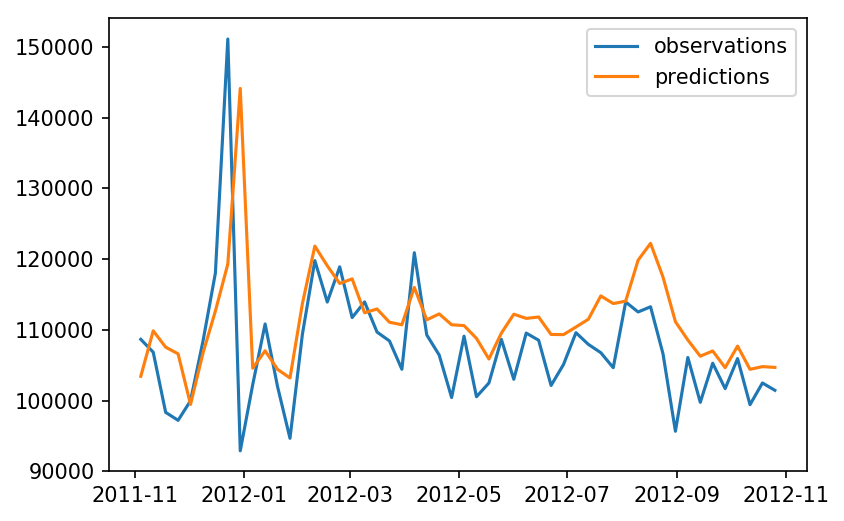

MAPE:  0.058316163528610535


In [5]:
base = Lookup_Method()
base.train(dep2train)
mape, predictions = base.test(dep2test)

plot_prediction_observation(predictions)
print("MAPE: ", mape)

## Question 2 [Random Forest]
Predict weekly sales using Random Forest (RF). Consider the two following setting.

Q2.1 (15%)  yt=f(yt−1,yt−2,yt−3,yt−4) .   
Q2.2 (15%)  yt=f(yt−1,yt−2,yt−3,yt−4,yt−52) .   
You should use the "Expanding Window" approach when evaluating the prediction accuracy. For each setting, report the MAPE and a plot of true and predicted values.

In [6]:
from sklearn.ensemble import RandomForestRegressor

class Random_Forest():
    
    def __init__(self):
        self.train_data = None
        self.model = None
    
    def train(self, data, lookBackDays, one_year_ago=False, estimators=100):
        self.train_data = pd.DataFrame(data)
        self.train_data["date"] = pd.to_datetime(self.train_data['date'])
        self.lookBackDays = lookBackDays
        self.one_year_ago = one_year_ago
        self._make_train_X()
        self.model = RandomForestRegressor(random_state=0, n_estimators=estimators)
        self.train_y = self.train_data.iloc[52:]["weeklySales"] if self.one_year_ago else self.train_data.iloc[self.lookBackDays:]["weeklySales"]
        self.model.fit(self.train_X, self.train_y)
        
    def _make_train_X(self):
        
        if self.one_year_ago:
            self.train_X = np.ndarray(shape=(0, self.lookBackDays+1))
            start_index = 52
        else:
            self.train_X = np.ndarray(shape=(0, self.lookBackDays))
            start_index = self.lookBackDays
        
        for index, row in self.train_data.iloc[start_index:].iterrows():
            x = np.zeros(self.lookBackDays+1) if self.one_year_ago else np.zeros(self.lookBackDays)
            for i in range(self.lookBackDays):
                x[i] = self.train_data.iloc[index-(self.lookBackDays-i)]["weeklySales"]
            if self.one_year_ago is True:
                x[self.lookBackDays] = self.train_data.iloc[index-52]["weeklySales"]
                
            self.train_X = np.vstack([self.train_X, x])
    
    def test_single(self, single_data):
        test_x = self.train_data.iloc[-self.lookBackDays:]["weeklySales"]
        if self.one_year_ago:
            test_x = test_x.append(pd.Series(self.train_data.iloc[-52]["weeklySales"]), ignore_index=True)
            
        self.train_data = self.train_data.append(single_data)
        return float(self.model.predict([test_x]))
            
    def test(self, testing_data):
        predictions = testing_data.apply(func=self.test_single, axis=1)
        mape = self.MAPE(predictions, testing_data["weeklySales"])
        return (mape, predictions)
    
    def MAPE(self, predictions, observations):
        predictions = list(predictions)
        observations = list(observations)
        
        if len(predictions) != len(observations):
            raise ValueError("MAPE: observations and predictions do not have equaul length.")
        
        mape = 0
        for i in range(len(predictions)):
            mape += abs((predictions[i] - observations[i])/observations[i])
        
        return mape/len(observations)

### Q2.1

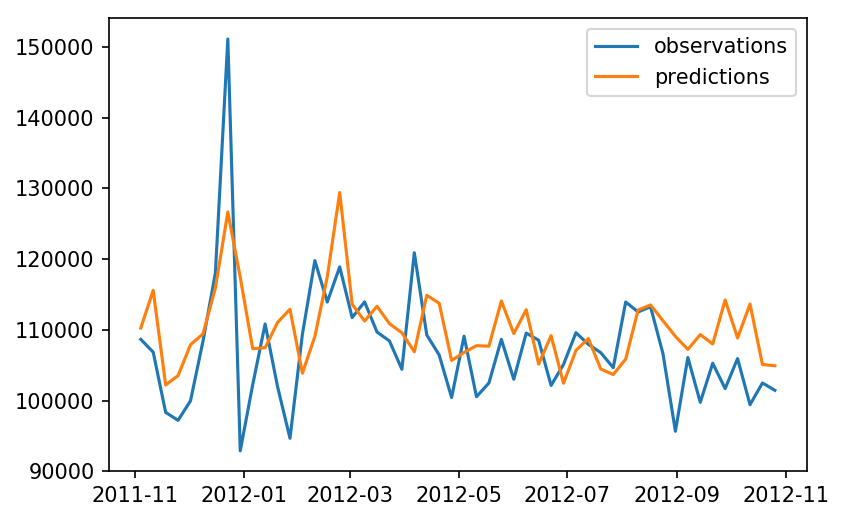

MAPE:  0.057822285011028075


In [7]:
rf = Random_Forest()
rf.train(dep2train, 4)
mape, predictions = rf.test(dep2test)

plot_prediction_observation(predictions)
print("MAPE: ", mape)

### Q2.2

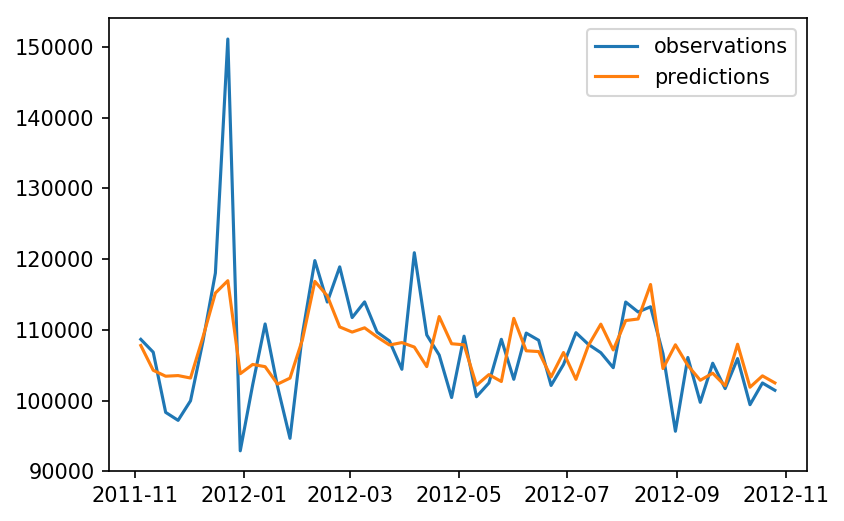

MAPE:  0.03678915637649744


In [8]:
rf2 = Random_Forest()
rf2.train(dep2train, 4, one_year_ago=True)
mape, predictions = rf2.test(dep2test)

plot_prediction_observation(predictions)
print("MAPE: ", mape)

## Question 3 [Gaussian Process Regression]
from sklearn.gaussian_process.kernels import ConstantKernel, RBFGaussian process regression (GPR) can be used to perform time series prediction. The input feature is simply the "week sequence number." You can construct this week sequence number from the calendar date. Each week sequence number is paired with its weekly sales. Your Gaussian process regression should have a kernel that contains the sum of an RBF kernel (sklearn.gaussian_process.kernels.RBF), an Exp-Sine-Squared kernel (sklearn.gaussian_process.kernels.ExpSineSquared), and a White noise kernel (sklearn.gaussian_process.kernels.WhiteKernel). The RBF kernel is used to capture near-by relations, the Exp-Sine-Squared kernel is used to capture seasonality, and the White noise kernel is used to model noise.

In [9]:
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from datetime import datetime, timedelta
import math

class GPR():
    
    def __init__(self, expanding_window=False, normalize=False):
        self.expanding_window = expanding_window
        self.normalize = normalize
        self.train_data = None
        self.model = None
        self.train_sales_mean = None
        self.train_sales_std = None
    
    def train(self, data, normalize=False):
        self.train_data = data
        self.train_data["date"] = pd.to_datetime(self.train_data['date'])
        self.train_X = np.array(self.train_data["date"].apply(func=self._week_squence_number))
        self.train_X = np.reshape(self.train_X, (len(self.train_X),1))
        self.train_Y = self.train_data["weeklySales"]
        if self.normalize:
            self.train_sales_mean = self.train_Y.mean()
            self.train_sales_std = self.train_Y.std()
            self.train_Y = (self.train_Y - self.train_sales_mean)/self.train_sales_std
        self.model = GaussianProcessRegressor(kernel=RBF()+ExpSineSquared()+WhiteKernel(), random_state=0)
        self.model.fit(self.train_X, self.train_Y)
        
    def _week_squence_number(self, date):
        delta = date - datetime(year=date.year, month=1, day=1)
        week = math.ceil((delta.days + 1)/7)
        return week
    
    def test_single(self, single_data):
        test_x = self._week_squence_number(single_data["date"])
        prediction = self.model.predict([[test_x]])
        
        if self.expanding_window:
            prediction = prediction * self.train_sales_std + self.train_sales_mean
            self.train_data = self.train_data.append(single_data)
            x = self._week_squence_number(single_data["date"])
            y = single_data["weeklySales"]
            if self.normalize:
                self.train_sales_mean = self.train_data["weeklySales"].mean()
                self.train_sales_std = self.train_data["weeklySales"].std()
                y = (single_data["weeklySales"]-self.train_sales_mean)/self.train_sales_std
            
            self.train_X = np.concatenate((self.train_X, [[x]]))
            self.train_Y = np.append(self.train_Y, y)
            self.model.fit(self.train_X, self.train_Y)
            
        return prediction
        
    
    def test(self, testing_data):
        testing_data["date"] = pd.to_datetime(testing_data["date"])
        predictions = testing_data.apply(func=self.test_single, axis=1)
        if self.normalize and self.expanding_window is False:
            predictions = predictions * self.train_sales_std + self.train_sales_mean
        mape = self.MAPE(predictions, testing_data["weeklySales"])
        return (mape, predictions)
    
    def MAPE(self, predictions, observations):
        predictions = list(predictions)
        observations = list(observations)
        
        if len(predictions) != len(observations):
            raise ValueError("MAPE: observations and predictions do not have equaul length.")
        
        mape = 0
        for i in range(len(predictions)):
            mape += abs((predictions[i] - observations[i])/observations[i])
        
        return mape/len(observations)

### Q3.1 (20%)
Normalize the weekly sales using training data so that the training data for GPR have a mean 0 and unit variance, and the test data also have a mean close to zero and a variance close to one. Train your model and make predictions. Be sure to transform the prediction data back to the original scale before computing MAPE.

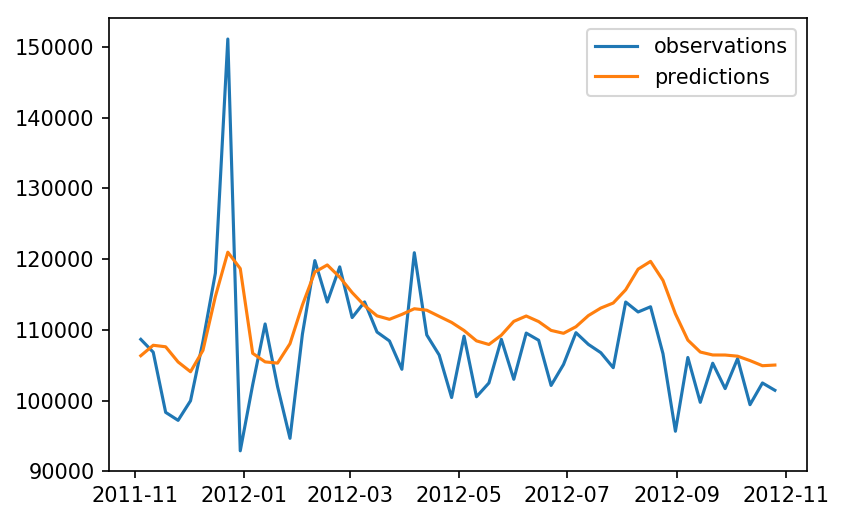

MAPE:  [0.05401288]


In [10]:
gpr1 = GPR(normalize=True)
gpr1.train(dep2train)
mape, predictions = gpr1.test(dep2test)

plot_prediction_observation(predictions)
print("MAPE: ", mape)

### Q3.2 (20%)
Repeat Q3.1 but use the original weekly sales instead of the transformed values.

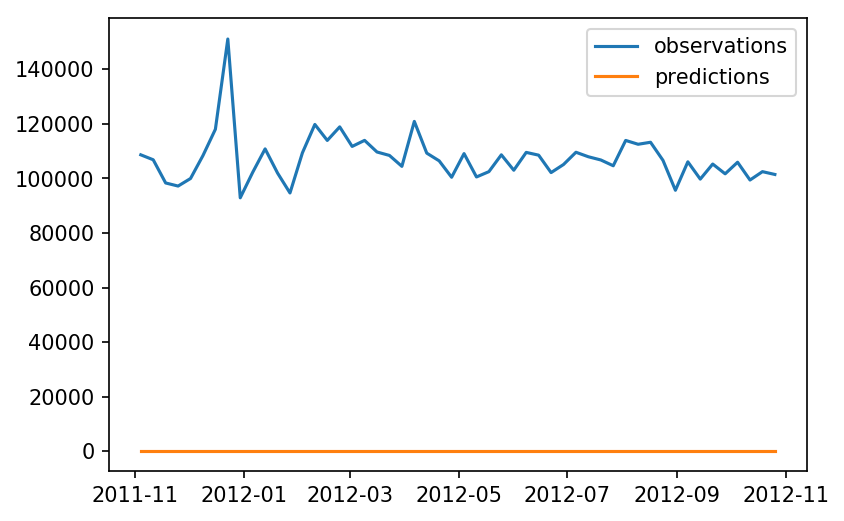

MAPE:  [0.99810666]


In [11]:
gpr2 = GPR()
gpr2.train(dep2train)
mape, predictions = gpr2.test(dep2test)

plot_prediction_observation(predictions)
print("MAPE: ", mape)

### Q3.3 (20%)
Selected the best model from Q3.1 and Q3.2. Use this model to perform "Expanding Window" approach and compute MAPE. Note that you do not need to retrain the model when each new test data arrive.

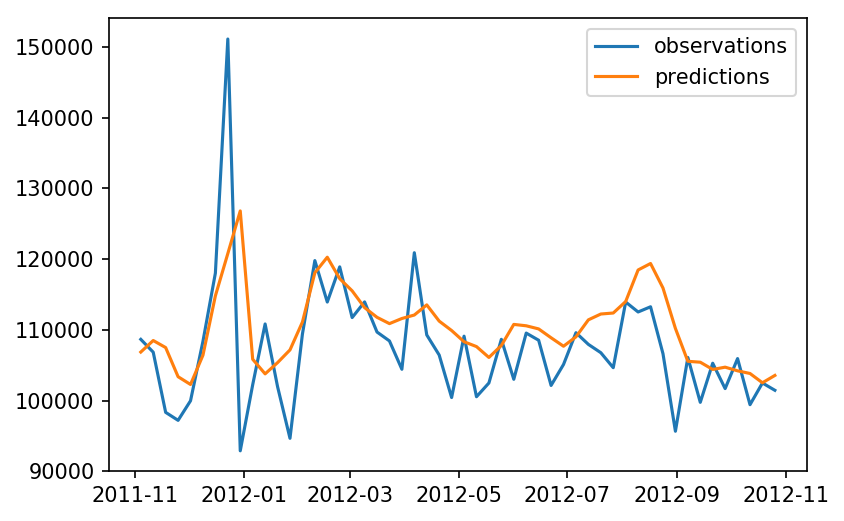

MAPE:  [0.04979453]


In [12]:
gpr3 = GPR(normalize=True, expanding_window=True)
gpr3.train(dep2train)
mape, predictions = gpr3.test(dep2test)

plot_prediction_observation(predictions)
print("MAPE: ", mape)

## Question 4 [Summarize and Discuss]
(10%) Summarize the prediction performance and discuss your findings.

<h4>Random Forest</h4>
For the random forest method, adding weekly sales from last year as a new feature improves the performance. <br>
This implies that there exists some repeatable pattern in each year that can help us in prediction.   
<br>
<h4>Gaussian Process Regression</h4>
Normalizing the y value is essential in GPR method, since the GP prior assumes that the mean is 0.<br>  
Also, using the "Expanding Window" method improves the performance.

## Bonus Question 4 [My Prediction Model]
(20%) This is a bonus question. Develop your own method. Your method should be different from the methods in Questions 1 to 3. Moreover, your method should deliver a MAPE that is better than the baseline model.

In [13]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import math
import statistics

class My_Method():
    
    def __init__(self):
        self.train_data = None
    
    def train(self, data):
        self.train_data = pd.DataFrame(data)
        self.train_data["date"] = pd.to_datetime(self.train_data['date'])
        self.earliest_date = min(self.train_data["date"])
    
    def test_single(self, single_data):
        date = single_data["date"]
        reference_date = date - timedelta(days=365)
        similar_train_date = min(self.train_data["date"], key=lambda x: abs(x - reference_date))

        if abs(reference_date - similar_train_date) > timedelta(days=7):
            raise BaseException("No data can be referred from training data.")
        
        if (self.train_data.date == date).any() is False:
            self.train_data = self.train_data.append(single_data)
            
        return float(self.train_data.loc[self.train_data["date"] == similar_train_date]["weeklySales"])
    
    def test(self, testing_data):
        predictions = testing_data.apply(func=self.test_single, axis=1)
        mape = self.MAPE(predictions, testing_data["weeklySales"])
        return (mape, predictions)
    
    def MAPE(self, predictions, observations):
        predictions = list(predictions)
        observations = list(observations)
        
        if len(predictions) != len(observations):
            raise ValueError("MAPE: observations and predictions do not have equaul length.")
        
        mape = 0
        for i in range(len(predictions)):
            mape += abs((predictions[i] - observations[i])/observations[i])
        
        return mape/len(observations)


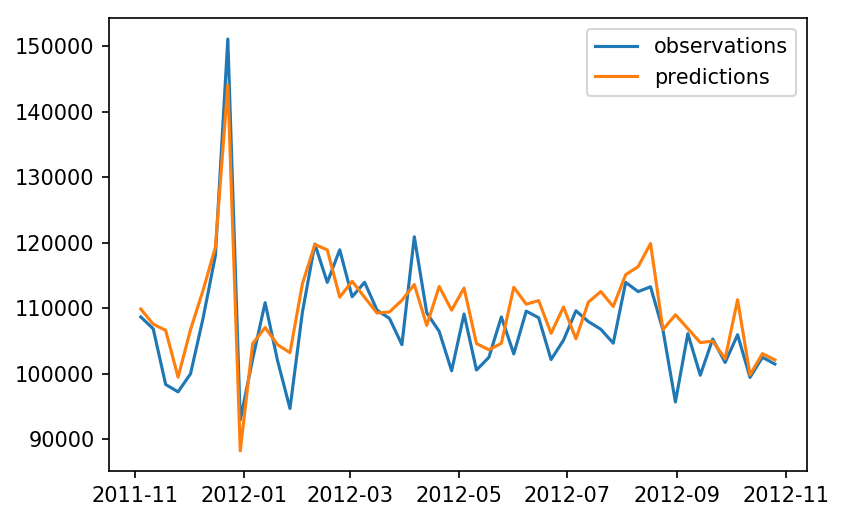

MAPE:  0.036570977139472924


In [14]:
myMethod = My_Method()
myMethod.train(dep2train)
mape, predictions = myMethod.test(dep2test)

plot_prediction_observation(predictions)
print("MAPE: ", mape)

This method is similar to the baseline method, however, instead of using the mean weekly sales of same week-of-year in training data, I directly use the weekly sales of similar days last year. Although this method seems naive and simple, it actually performs really well, and it needs no time to train as well.